In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
from functools import lru_cache
from collections import defaultdict

import tqdm
import numpy as np
import pandas as pd
pd.options.display.max_columns=100
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import LabelShuffleSplit

%matplotlib inline

/home/a.safiullin/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path_to_train = './data/train_set.csv'
path_to_test = './data/test_set.csv'

In [3]:
dt_tr = pd.read_csv(path_to_train)
dt_ts = pd.read_csv(path_to_test)

dt_tr.columns = ['amount', 'atm_address', 'atm_address_lat', 'atm_address_lon', 'city',
       'country', 'currency', 'customer_id', 'home_add_lat', 'home_add_lon',
       'mcc', 'pos_address', 'pos_address_lat', 'pos_address_lon', 'terminal_id',
       'transaction_date', 'work_add_lat', 'work_add_lon']

dt_ts.mcc = dt_ts.mcc.apply(lambda x: str(x).replace(',', '')).astype(int)

In [4]:
dt_ts.shape, dt_tr.shape

((1265470, 14), (1224734, 18))

In [5]:
dt_tr['lat'] = -1
dt_tr['lon'] = -1

dt_ts['lat'] = -1
dt_ts['lon'] = -1

dt_tr['is_atm_coords'] = -1
dt_ts['is_atm_coords'] = -1

dt_tr['lat'][~np.isnan(dt_tr.atm_address_lat)] = dt_tr.atm_address_lat[~np.isnan(dt_tr.atm_address_lat)]
dt_tr['lon'][~np.isnan(dt_tr.atm_address_lon)] = dt_tr.atm_address_lon[~np.isnan(dt_tr.atm_address_lon)]

dt_tr['lat'][~np.isnan(dt_tr.pos_address_lat)] = dt_tr.pos_address_lat[~np.isnan(dt_tr.pos_address_lat)]
dt_tr['lon'][~np.isnan(dt_tr.pos_address_lon)] = dt_tr.pos_address_lon[~np.isnan(dt_tr.pos_address_lon)]

dt_ts['lat'][~np.isnan(dt_ts.atm_address_lat)] = dt_ts.atm_address_lat[~np.isnan(dt_ts.atm_address_lat)]
dt_ts['lon'][~np.isnan(dt_ts.atm_address_lon)] = dt_ts.atm_address_lon[~np.isnan(dt_ts.atm_address_lon)]

dt_ts['lat'][~np.isnan(dt_ts.pos_address_lat)] = dt_ts.pos_address_lat[~np.isnan(dt_ts.pos_address_lat)]
dt_ts['lon'][~np.isnan(dt_ts.pos_address_lon)] = dt_ts.pos_address_lon[~np.isnan(dt_ts.pos_address_lon)]


dt_tr['is_atm_coords'][~np.isnan(dt_tr.pos_address_lat)] = 0
dt_tr['is_atm_coords'][~np.isnan(dt_tr.atm_address_lat)] = 1

dt_ts['is_atm_coords'][~np.isnan(dt_ts.pos_address_lat)] = 0
dt_ts['is_atm_coords'][~np.isnan(dt_ts.atm_address_lat)] = 1

In [6]:
dt_ts.shape, dt_tr.shape

((1265470, 17), (1224734, 21))

In [7]:
is_home = np.sqrt((dt_tr.home_add_lat - dt_tr.lat) ** 2 + (dt_tr.home_add_lon - dt_tr.lon) ** 2) <= 0.02
is_work = np.sqrt((dt_tr.work_add_lat - dt_tr.lat) ** 2 + (dt_tr.work_add_lon - dt_tr.lon) ** 2) <= 0.02

In [8]:
dt_tr['is_home'] = is_home.astype(int)
dt_tr['is_work'] = is_work.astype(int)

dt_ts['is_home'] = np.nan
dt_ts['is_work'] = np.nan

##### Label encoder

In [9]:
le = {}
tmp = pd.concat((dt_ts, dt_tr))
for col in ['country', 'currency', 'city']:
    print(col)
    le[col] = LabelEncoder()
    le[col].fit(tmp[col].fillna(-1).astype('str'))
    dt_tr[col] = le[col].transform(dt_tr[col].fillna(-1).astype('str'))
    dt_ts[col] = le[col].transform(dt_ts[col].fillna(-1).astype('str'))

country
currency
city


##### City and distance.

In [10]:
if os.path.exists('data/centres_of_cities.csv'):
    centres_of_cities = pd.read_csv('data/centres_of_cities.csv')
else:
    centres_of_cities = pd.read_html('http://alextyurin.ru/?p=1037')
    centres_of_cities = centres_of_cities[0].loc[3:92, ['Город', 'Широта', 'Долгода']]
    centres_of_cities.columns = ['city',  'lat', 'lon']
    centres_of_cities = centres_of_cities.reset_index()
    centres_of_cities.to_csv('data/centres_of_cities.csv', index=False)
    
nn = NearestNeighbors(n_neighbors=1, p=2, n_jobs=6)
nn.fit(centres_of_cities[[ 'lat', 'lon']].astype(float).values)

def get_nearest_city(tr, ts):
    """
    Used additional data  - coordinates of cities centers.
    """
    tr_data = tr.copy().fillna(-1)
    ts_data = ts.copy().fillna(-1)
    cols = ['lat', 'lon']
    
    dt = pd.concat([tr_data[cols], ts_data[cols]], axis=0)
    a = nn.kneighbors(dt[cols].values)[1].flatten()
    dist = nn.kneighbors(dt[cols].values)[0].flatten()
    b,c = np.unique(a, return_counts=True)
    maper = {k:v for k,v in zip(b, c)}
    a = list(map(lambda x: maper[x], a))
    tr_data['city_count_enc'] = a[:tr_data.shape[0]]
    ts_data['city_count_enc'] = a[-ts_data.shape[0]:]
    tr_data['city_dist'] = dist[:tr_data.shape[0]]
    ts_data['city_dist'] = dist[-ts_data.shape[0]:]
    return tr_data, ts_data

dt_tr, dt_ts = get_nearest_city(dt_tr, dt_ts)

##### std inside terminals lat

In [11]:
tmp = pd.concat((dt_tr, dt_ts), ignore_index=True).groupby('terminal_id').lat.std().fillna(0).rename('std_in_terminal').reset_index()

dt_tr = pd.merge(dt_tr, tmp, on='terminal_id', how='left')
dt_ts = pd.merge(dt_ts, tmp, on='terminal_id', how='left')

##### terminal counter

In [12]:
tmp = pd.concat((dt_tr['terminal_id'], dt_ts['terminal_id'])).value_counts().rename('terminal_id_counter').reset_index()
tmp.columns = ['terminal_id', 'terminal_id_counter']

dt_tr = pd.merge(tmp, dt_tr, on='terminal_id')
dt_ts = pd.merge(tmp, dt_ts, on='terminal_id')

In [13]:
tmp = pd.concat((dt_tr, dt_ts), ignore_index=True).groupby('terminal_id').city_count_enc.nunique().rename('count_cities_inside_terminal').reset_index()

dt_tr = pd.merge(dt_tr, tmp, on='terminal_id', how='left')
dt_ts = pd.merge(dt_ts, tmp, on='terminal_id', how='left')

##### counter description for each customer: number of unique city, mcc, terminal

In [14]:
tmp = dt_tr.groupby('customer_id').mcc.nunique().rename('mcc_count_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').mcc.nunique().rename('mcc_count_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

###
tmp = dt_tr.groupby('customer_id').terminal_id.nunique().rename('terminal_id_count_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').terminal_id.nunique().rename('terminal_id_count_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

####
tmp = dt_tr.groupby('customer_id').city_count_enc.nunique().rename('city_count_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').city_count_enc.nunique().rename('city_count_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

##### mean description for each customer: proportion of atm transactions for each customer, mean city dist,  mean amount

In [15]:
tmp = dt_tr.groupby('customer_id').is_atm_coords.mean().rename('atm_ratio_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').is_atm_coords.mean().rename('atm_ratio_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

###
tmp = dt_tr.groupby('customer_id').city_dist.mean().rename('city_dist_mean_per_customer').reset_index()
dt_tr = pd.merge(dt_tr, tmp, left_on='customer_id', right_on='customer_id')

tmp = dt_ts.groupby('customer_id').city_dist.mean().rename('city_dist_mean_per_customer').reset_index()
dt_ts = pd.merge(dt_ts, tmp, left_on='customer_id', right_on='customer_id')

###
a = dt_tr.groupby(['customer_id']).amount.mean().rename('amount_mean').reset_index()
b = dt_ts.groupby(['customer_id']).amount.mean().rename('amount_mean').reset_index()

dt_tr = pd.merge(dt_tr, a, left_on=['customer_id'], right_on=['customer_id'])
dt_ts = pd.merge(dt_ts, b, left_on=['customer_id'], right_on=['customer_id'])

##### percent encoding for each mcc

In [16]:
a = dt_tr.groupby('customer_id').mcc.value_counts().rename('mcc_counter').reset_index()
a['mcc_counter'] = a.groupby('customer_id').mcc_counter.apply(lambda x: x / x.sum())
dt_tr = pd.merge(dt_tr, a, left_on=['customer_id', 'mcc'], right_on=['customer_id', 'mcc'])

b = dt_ts.groupby('customer_id').mcc.value_counts().rename('mcc_counter').reset_index()
b['mcc_counter'] = b.groupby('customer_id').mcc_counter.apply(lambda x: x / x.sum())
dt_ts = pd.merge(dt_ts, b, left_on=['customer_id', 'mcc'], right_on=['customer_id', 'mcc'])

##### time features

In [17]:
%%time

dt_tr.transaction_date = pd.to_datetime(dt_tr.transaction_date)
dt_ts.transaction_date = pd.to_datetime(dt_ts.transaction_date)

tmp = dt_tr.groupby('customer_id').transaction_date.max() - dt_tr.groupby('customer_id').transaction_date.min()
tmp = tmp.rename('num_of_days').reset_index()
tmp.num_of_days = tmp.num_of_days.apply(lambda x: x.days)
dt_tr = pd.merge(dt_tr, tmp, on='customer_id')

tmp = dt_ts.groupby('customer_id').transaction_date.max() - dt_ts.groupby('customer_id').transaction_date.min()
tmp = tmp.rename('num_of_days').reset_index()
tmp.num_of_days = tmp.num_of_days.apply(lambda x: x.days)
dt_ts = pd.merge(dt_ts, tmp, on='customer_id')

dt_tr['day_of_week'] = dt_tr['transaction_date'].apply(lambda x: x.date().weekday())
dt_tr['is_weekend'] = dt_tr['transaction_date'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

dt_ts['day_of_week'] = dt_ts['transaction_date'].apply(lambda x: x.date().weekday())
dt_ts['is_weekend'] = dt_ts['transaction_date'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

CPU times: user 48.4 s, sys: 1.4 s, total: 49.8 s
Wall time: 49.7 s


##### based on customer_id  and distance  features

##### считает парные расстоянияния между всеми наблюдениями

##### популярность окрестности

##### группируем - и считаем статистики внутри группы - по кастомер айди

In [19]:
def in_merchant_dist_features(data, latitude='', longitude='', pref='_'):
    """
    Some aggreg features for nearest neighbors like:
    - TODO ? should i add some noise - for avoiding one id leak?
    -
    """
    dt = data.copy()
    
    # std lat & lon
    tmp = dt.groupby('customer_id')[latitude].std().reset_index()
    tmp.columns = ['customer_id', 'dist_lat_std'+pref]
    dt = pd.merge(dt, tmp, how='left', on='customer_id')
    
    tmp = dt.groupby('customer_id')[longitude].std().reset_index()
    tmp.columns = ['customer_id', 'dist_lon_std'+pref]
    dt = pd.merge(dt, tmp, how='left', on='customer_id')
    
    dt.set_value(dt['dist_lat_std'+pref] != dt['dist_lat_std'+pref], 'dist_lat_std'+pref, -1)
    dt.set_value(dt['dist_lon_std'+pref] != dt['dist_lon_std'+pref], 'dist_lon_std'+pref, -1)
    
    dt['dist_std'+pref] = np.sqrt(dt['dist_lat_std'+pref].values ** 2 + dt['dist_lon_std'+pref].values ** 2)
    dt = dt.drop(['dist_lat_std'+pref, 'dist_lon_std'+pref], axis=1)
    
    
#     tmp = dt.groupby('customer_id')[latitude].median().reset_index()
#     tmp.columns = ['customer_id', 'lat_median']
#     tmp = pd.merge(dt, tmp, how='left', on='customer_id')
#     dt['dist_to_median_lat'+pref] = np.abs(tmp[latitude].values - tmp.lat_median.values)
    
    
    
    # dist to mean and to median
    tmp = dt.groupby('customer_id')[latitude].mean().reset_index()
    tmp.columns = ['customer_id', 'lat_mean']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_mean_lat'+pref] = np.abs(tmp[latitude].values - tmp.lat_mean.values)
    
    tmp = dt.groupby('customer_id')[longitude].mean().reset_index()
    tmp.columns = ['customer_id', 'lon_mean']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_mean_lon'+pref] = np.abs(tmp[longitude].values - tmp.lon_mean.values)
    
    # to median
    tmp = dt.groupby('customer_id')[latitude].median().reset_index()
    tmp.columns = ['customer_id', 'lat_median']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_median_lat'+pref] = np.abs(tmp[latitude].values - tmp.lat_median.values)
    
    tmp = dt.groupby('customer_id')[longitude].median().reset_index()
    tmp.columns = ['customer_id', 'lon_median']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_median_lon'+pref] = np.abs(tmp[longitude].values - tmp.lon_median.values)
    
    # to mode
    tmp = dt.groupby('customer_id')[longitude].apply(lambda x:x.value_counts().index[0]).reset_index()
    tmp.columns = ['customer_id', 'lon_mode']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_mode_lon'+pref] = np.abs(tmp[longitude].values - tmp.lon_mode.values)
    
    tmp = dt.groupby('customer_id')[latitude].apply(lambda x:x.value_counts().index[0]).reset_index()
    tmp.columns = ['customer_id', 'lat_mode']
    tmp = pd.merge(dt, tmp, how='left', on='customer_id')
    dt['dist_to_mode_lat'+pref] = np.abs(tmp[latitude].values - tmp.lat_mode.values)
    
    ##### ____
    
    dt['dist_to_mean_'+pref] = np.sqrt(dt['dist_to_mean_lat'+pref].values ** 2 +
                                       dt['dist_to_mean_lon'+pref].values ** 2)
    dt = dt.drop(['dist_to_mean_lat'+pref, 'dist_to_mean_lon'+pref], axis=1)
    
    dt['dist_to_median_'+pref] = np.sqrt(dt['dist_to_median_lat'+pref].values ** 2 +
                                       dt['dist_to_median_lon'+pref].values ** 2)
    dt = dt.drop(['dist_to_median_lat'+pref, 'dist_to_median_lon'+pref], axis=1)
    
    dt['dist_to_mode_'+pref] = np.sqrt(dt['dist_to_mode_lat'+pref].values ** 2 +
                                       dt['dist_to_mode_lon'+pref].values ** 2)
    dt = dt.drop(['dist_to_mode_lat'+pref, 'dist_to_mode_lon'+pref], axis=1)
    
    return dt

In [20]:
%%time

dt_tr = in_merchant_dist_features(dt_tr[dt_tr.lat!=-1], latitude='lat', longitude='lon', pref='+')
dt_ts = in_merchant_dist_features(dt_ts[dt_ts.lat!=-1], latitude='lat', longitude='lon', pref='+')

CPU times: user 1min 5s, sys: 11.2 s, total: 1min 16s
Wall time: 1min 16s


Save temperary file

##### Признаки на ближайших транзакциях

In [21]:
main_cols = ['customer_id', 'terminal_id', 'mcc', 'lat', 'lon']
dt_tr[main_cols].head()

,customer_id,terminal_id,mcc,lat,lon
0,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.909,30.324
1,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.327
2,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.320
3,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.323
4,fe921930d0bf2cc479e89fecdb538d29,c72a266bbcea842b2cbbe5809349d609,6011,59.906,30.326


In [22]:
@lru_cache(maxsize=15000)
def cached_req_neigbours(nnoy, query, num_nn):
    return nnoy.query([query], k=num_nn, dualtree=True, sort_results=True)

@lru_cache(maxsize=15000)
def cached_req_radius(nnoy, query, radius):
    return nnoy.query_radius([query], r=radius)

In [23]:
def get_extra_features(df, group_by_columns):
    assert isinstance(group_by_columns, list)
    assert len(group_by_columns) 
    
    dt = df.copy()
    LABEL = 'label'
    PREF = 'group_features_'+'_'.join(group_by_columns)
    COORDINATES = ["lat", "lon"]
    tmp = dt.groupby(group_by_columns).size().reset_index(name=LABEL)
    tmp.label = list(range(len(tmp[LABEL])))
    dt = pd.merge(dt, tmp, on=group_by_columns)
    
    groupby_dt = dt.groupby(LABEL)
    nnoy = {}
    for indx_id, transactions_group in tqdm.tqdm(groupby_dt):
        nnoy[indx_id] = KDTree(transactions_group[COORDINATES].values, metric='minkowski', p=2)
    
    features = defaultdict(list)
    
    cols_ = list(dt.columns)
    for row in tqdm.tqdm(dt.values):
        row = row
        label_value = row[cols_.index(LABEL)]
        query = (row[cols_.index(COORDINATES[0])], row[cols_.index(COORDINATES[1])])
        for num_nn in [10, 25, 50]:
            num_nn = int(num_nn)
            try:
#                 [distances], [neighbor_ids] = nnoy[label_value].query([query],k=num_nn,
#                                                                       dualtree=True,sort_results=True)
                [distances], [neighbor_ids] = cached_req_neigbours(nnoy[label_value], query, num_nn)
            except ValueError:
                distances = [-1 for i in range(num_nn)]
                
            features[PREF+'_dist_to_nearest_for_{}_var'.format(num_nn)].append(np.var(distances))
            features[PREF+'_dist_to_nearest_for_{}_min'.format(num_nn)].append(np.min(distances))
            features[PREF+'_dist_to_nearest_for_{}_mean'.format(num_nn)].append(np.mean(distances))
            
            for percentile in [20., 50., 70., 90.]:
#                 perc_value = np.percentile(distances, percentile)
                perc_value = distances[int((len(distances)-1) * percentile / 100)]
                features[PREF+'dist_to_nearest_for_{}_percentile{}'.format(num_nn, percentile)].append(perc_value)
            
        for radius in [0.005, 0.01, 0.015, 0.02, 0.023]:
#             [cnt] = nnoy[label_value].query_radius([query], r=radius)
            [cnt] = cached_req_radius(nnoy[label_value], query, radius)
            features[PREF+'_nearest_count_in_r_{}'.format(radius)].append(len(cnt))
        
    for feature_name in features:
        dt[feature_name] = features[feature_name]
    
    return dt.drop(LABEL, axis=1)

In [24]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

In [25]:
%%time
dt_tr = get_extra_features(dt_tr, ["customer_id"])
dt_ts = get_extra_features(dt_ts, ["customer_id"])

100%|██████████| 1166971/1166971 [23:11<00:00, 838.49it/s]


CPU times: user 46min 57s, sys: 57.2 s, total: 47min 54s
Wall time: 47min 22s


In [ ]:
cached_req_neigbours.cache_clear()
cached_req_radius.cache_clear()

In [ ]:
%%time
dt_tr = get_extra_features(dt_tr, ["customer_id", 'mcc'])
dt_ts = get_extra_features(dt_ts, ["customer_id", 'mcc'])

 84%|████████▍ | 951069/1127294 [20:04<03:43, 789.51it/s]

In [ ]:
%%time
dt_tr.drop(['atm_address', 'pos_address'], axis=1).to_hdf('data/precomputed_train.h5', 
                                                          'pre_train', format = 'table', mode='w') 
dt_ts.drop(['atm_address', 'pos_address'], axis=1).to_hdf('data/precomputed_test.h5', 
                                                          'pre_train', format = 'table', mode='w') 

In [31]:
!ls -lh data

итого 2,2G
-rw------- 1 a.safiullin a.safiullin 3,7K фев 28 19:43 centres_of_cities.csv
-rw------- 1 a.safiullin a.safiullin 847M мар  5 02:37 precomputed_test.h5
-rw------- 1 a.safiullin a.safiullin 853M мар  5 02:37 precomputed_train.h5
-rw------- 1 a.safiullin a.safiullin 237M фев 14 19:48 test_set.csv
-rw------- 1 a.safiullin a.safiullin 263M фев 14 19:51 train_set.csv


In [32]:
dt_tr.shape

(1127294, 94)

##### prepare to ml

In [33]:
a = dt_tr[['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']].copy()
a = a[['customer_id', 'home_add_lat', 'home_add_lon', 'work_add_lat', 'work_add_lon']]
a = a[~a['customer_id'].duplicated()]

In [34]:
cols = list(set(dt_tr.columns) - set([ 'atm_address', 'atm_address_lat', 'atm_address_lon', 
                                       'home_add_lat', 'home_add_lon', 
                                       'pos_address', 'pos_address_lat', 'pos_address_lon', 
                                       'terminal_id', 'transaction_date', 
                                       'work_add_lat', 'work_add_lon', 'lat_mean_', 'lon_mean_',
                                      ]))

In [35]:
dt_tr = dt_tr[cols]
dt_ts = dt_ts[cols]

In [36]:
trshape = dt_tr.shape[0]
tsshape = dt_ts.shape[0]

dt_tr = pd.concat((dt_tr, dt_tr), ignore_index=True)
dt_ts = pd.concat((dt_ts, dt_ts), ignore_index=True)

dt_tr['target_ishome'] = 1
dt_tr.loc[trshape:, 'target_ishome'] = 0
dt_ts['target_ishome'] = 1
dt_ts.loc[tsshape:, 'target_ishome'] = 0

dt_tr['target'] = -1
dt_tr.loc[:trshape, 'target'] = dt_tr.loc[:trshape, 'is_home']
dt_tr.loc[trshape:, 'target'] = dt_tr.loc[trshape:, 'is_work']

##### validation

In [37]:
cv = LabelShuffleSplit(dt_tr['customer_id'].values, n_iter=1, 
                       test_size=0.3, random_state=1)

score = []
for train_idx, test_idx in cv:
    pass

X_tr, X_ts = dt_tr.iloc[train_idx], dt_tr.iloc[test_idx]

In [38]:
assert set(X_tr.customer_id) & set(X_ts.customer_id) == set()

In [39]:
target = 'target'

In [40]:
y_tr = X_tr[target]
y_ts = X_ts[target]

In [41]:
X_tr.columns

Index(['group_features_customer_id_nearest_count_in_r_0.01',
       'group_features_customer_id_mccdist_to_nearest_for_25_percentile90.0',
       'mcc_counter',
       'group_features_customer_id_mccdist_to_nearest_for_25_percentile70.0',
       'dist_to_mean_+', 'is_home', 'day_of_week', 'lat', 'dist_std+',
       'group_features_customer_id_mccdist_to_nearest_for_50_percentile20.0',
       'group_features_customer_id_mcc_dist_to_nearest_for_50_var',
       'terminal_id_counter',
       'group_features_customer_id_mccdist_to_nearest_for_10_percentile70.0',
       'group_features_customer_id_dist_to_nearest_for_50_min',
       'group_features_customer_id_dist_to_nearest_for_10_min',
       'group_features_customer_iddist_to_nearest_for_10_percentile20.0',
       'currency', 'city', 'city_count_enc',
       'group_features_customer_id_mcc_dist_to_nearest_for_10_mean',
       'atm_ratio_per_customer', 'lon',
       'group_features_customer_id_dist_to_nearest_for_50_var',
       'std_in_t

In [42]:
X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon', 'target'], axis=1)
X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon', 'target'], axis=1)

In [43]:
import lightgbm as lgb

In [44]:
lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))
lgb_eval = lgb.Dataset(X_ts.values, y_ts.values, reference=lgb_train)

In [45]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc'],
    'max_depth':12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'num_leaves': 1024,
    'learning_rate': 0.02,
    'feature_fraction_seed':4242,
    'bagging_seed':4242,
    'data_random_seed':4242,
    'nthread': 6,
}

In [46]:
evals_result = {} 
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=600,
                verbose_eval=10,
                evals_result=evals_result,
                valid_sets=lgb_eval,
                early_stopping_rounds=50)

Start training...
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.816066
[20]	valid_0's auc: 0.824239
[30]	valid_0's auc: 0.829324
[40]	valid_0's auc: 0.831036
[50]	valid_0's auc: 0.831523
[60]	valid_0's auc: 0.833066
[70]	valid_0's auc: 0.834694
[80]	valid_0's auc: 0.835477
[90]	valid_0's auc: 0.836561
[100]	valid_0's auc: 0.837314
[110]	valid_0's auc: 0.837737
[120]	valid_0's auc: 0.838821
[130]	valid_0's auc: 0.839607
[140]	valid_0's auc: 0.84018
[150]	valid_0's auc: 0.840641
[160]	valid_0's auc: 0.841188
[170]	valid_0's auc: 0.842142
[180]	valid_0's auc: 0.842893
[190]	valid_0's auc: 0.8431
[200]	valid_0's auc: 0.84351
[210]	valid_0's auc: 0.843948
[220]	valid_0's auc: 0.844197
[230]	valid_0's auc: 0.844589
[240]	valid_0's auc: 0.844419
[250]	valid_0's auc: 0.844182
[260]	valid_0's auc: 0.844188
[270]	valid_0's auc: 0.844135
[280]	valid_0's auc: 0.844254
Early stopping, best iteration is:
[230]	valid_0's auc: 0.844589


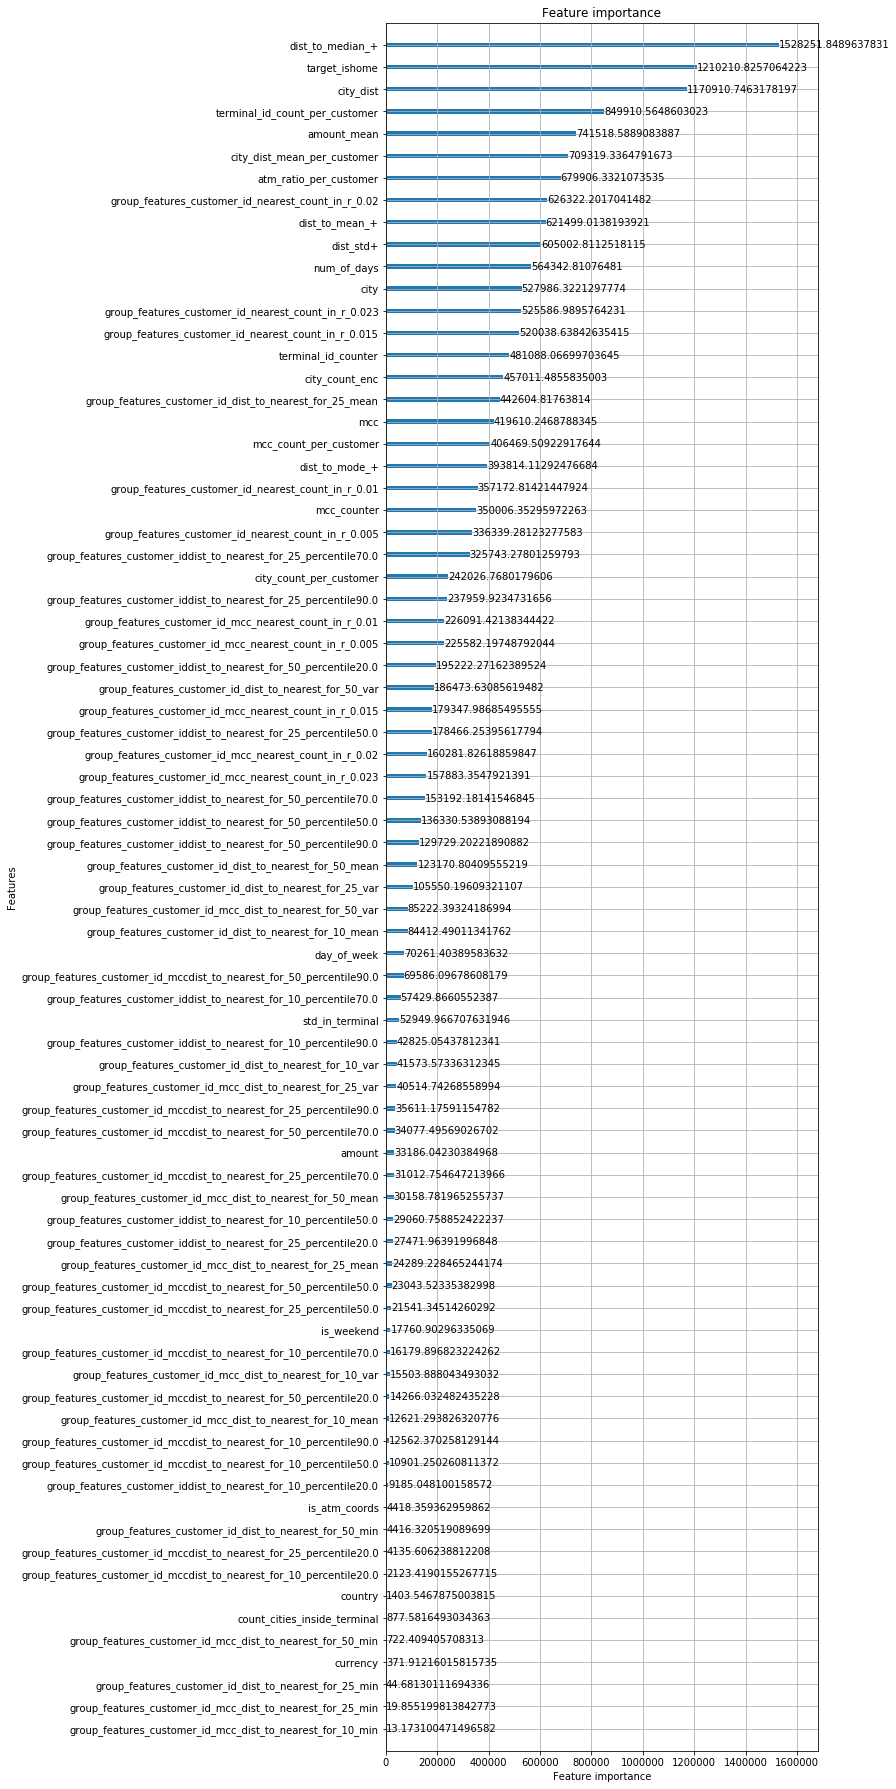

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 30))
ax = fig.add_axes([0.1, 0.4, 0.6, 0.8])
lgb.plot_importance(gbm, ax, importance_type='gain', max_num_features=-1)

In [48]:
preds = pd.DataFrame()
cv = LabelShuffleSplit(dt_tr['customer_id'].values, n_iter=5, 
                       test_size=0.3, random_state=2)
score = []
for train_idx, test_idx in cv:
    pass

target = 'target'

X_tr, X_ts = dt_tr.iloc[train_idx], dt_tr.iloc[test_idx]

y_tr = X_tr[target]

X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon', 'target'], axis=1)

X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon', 'target'], axis=1)

lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))

print('Start training...')
gbm = lgb.train(params, lgb_train, num_boost_round=250)

Start training...


In [49]:
preds[target] = gbm.predict(X_ts)

In [50]:
tmp = dt_tr.iloc[test_idx].reset_index()

In [51]:
dt_tr.head()

,group_features_customer_id_nearest_count_in_r_0.01,group_features_customer_id_mccdist_to_nearest_for_25_percentile90.0,mcc_counter,group_features_customer_id_mccdist_to_nearest_for_25_percentile70.0,dist_to_mean_+,is_home,day_of_week,lat,dist_std+,group_features_customer_id_mccdist_to_nearest_for_50_percentile20.0,group_features_customer_id_mcc_dist_to_nearest_for_50_var,terminal_id_counter,group_features_customer_id_mccdist_to_nearest_for_10_percentile70.0,group_features_customer_id_dist_to_nearest_for_50_min,group_features_customer_id_dist_to_nearest_for_10_min,group_features_customer_iddist_to_nearest_for_10_percentile20.0,currency,city,city_count_enc,group_features_customer_id_mcc_dist_to_nearest_for_10_mean,atm_ratio_per_customer,lon,group_features_customer_id_dist_to_nearest_for_50_var,std_in_terminal,city_count_per_customer,group_features_customer_iddist_to_nearest_for_25_percentile50.0,group_features_customer_iddist_to_nearest_for_25_percentile90.0,group_features_customer_id_dist_to_nearest_for_50_mean,group_features_customer_id_mcc_dist_to_nearest_for_50_min,group_features_customer_id_mccdist_to_nearest_for_50_percentile90.0,group_features_customer_id_dist_to_nearest_for_25_min,amount_mean,num_of_days,group_features_customer_iddist_to_nearest_for_25_percentile20.0,group_features_customer_id_mccdist_to_nearest_for_25_percentile50.0,group_features_customer_id_nearest_count_in_r_0.005,group_features_customer_id_dist_to_nearest_for_25_var,group_features_customer_id_nearest_count_in_r_0.015,dist_to_mode_+,count_cities_inside_terminal,group_features_customer_iddist_to_nearest_for_10_percentile90.0,country,amount,city_dist_mean_per_customer,group_features_customer_id_mcc_dist_to_nearest_for_25_min,group_features_customer_id_nearest_count_in_r_0.02,group_features_customer_iddist_to_nearest_for_50_percentile20.0,terminal_id_count_per_customer,group_features_customer_id_mcc_nearest_count_in_r_0.005,city_dist,group_features_customer_id_mcc_nearest_count_in_r_0.02,group_features_customer_id_dist_to_nearest_for_10_mean,group_features_customer_iddist_to_nearest_for_10_percentile70.0,dist_to_median_+,mcc_count_per_customer,group_features_customer_id_mccdist_to_nearest_for_10_percentile90.0,is_atm_coords,group_features_customer_id_mcc_nearest_count_in_r_0.015,group_features_customer_id_mcc_nearest_count_in_r_0.01,group_features_customer_id_mccdist_to_nearest_for_10_percentile50.0,mcc,group_features_customer_id_mccdist_to_nearest_for_50_percentile50.0,group_features_customer_id_mcc_dist_to_nearest_for_10_var,is_work,group_features_customer_id_mccdist_to_nearest_for_25_percentile20.0,group_features_customer_id_mcc_dist_to_nearest_for_25_mean,group_features_customer_iddist_to_nearest_for_50_percentile70.0,group_features_customer_id_dist_to_nearest_for_25_mean,group_features_customer_id_mccdist_to_nearest_for_10_percentile20.0,group_features_customer_id_mcc_dist_to_nearest_for_50_mean,group_features_customer_id_nearest_count_in_r_0.023,group_features_customer_iddist_to_nearest_for_50_percentile90.0,group_features_customer_iddist_to_nearest_for_10_percentile50.0,group_features_customer_id_mcc_dist_to_nearest_for_25_var,group_features_customer_iddist_to_nearest_for_25_percentile70.0,customer_id,group_features_customer_iddist_to_nearest_for_50_percentile50.0,group_features_customer_id_mcc_dist_to_nearest_for_10_min,group_features_customer_id_mccdist_to_nearest_for_50_percentile70.0,group_features_customer_id_mcc_nearest_count_in_r_0.023,group_features_customer_id_dist_to_nearest_for_10_var,is_weekend,target_ishome,target
0,83,0.003162,0.716049,0.002828,0.015880,0,0,59.909,0.013209,0.002236,1.918395e-06,1306,0.002000,0.0,0.0,0.000,42,7811,525977,0.001412,0.703704,30.324,1.918395e-06,0.00233,2,0.002236,0.003162,0.003356,0.0,0.005099,0.0,3.036517,304,0.001414,0.002236,44,7.987560e-07,83,0.028354,1,0.002236,129,3.321506,0.399293,0.0,84,0.002236,28,44,0.031351,82,0.001412,0.002000,0.008062,8,0.002236,1,82,82,0.001414,6011,0.003162,7.055732e-07,

In [52]:
coords = tmp[['lat', 'lon']]
coords['prob'] = -1
coords['customer_id'] = tmp.customer_id

coords['prob_is_home'] = -1 
coords['prob_is_work'] = -1 
coords.loc[dt_tr.iloc[test_idx].target_ishome.values == 1, 'prob_is_home'] = preds.target[dt_tr.iloc[test_idx].target_ishome.values == 1]
coords.loc[dt_tr.iloc[test_idx].target_ishome.values == 0, 'prob_is_work'] = preds.target[dt_tr.iloc[test_idx].target_ishome.values == 0]


coords['home_ans'] = 0
idx = coords[~np.isnan(coords.prob_is_home.values)].groupby('customer_id')['prob_is_home'].apply(np.argmax).reset_index()['prob_is_home']
coords.loc[idx, 'home_ans'] = 1

coords['work_ans'] = 0
idx = coords[~np.isnan(coords.prob_is_work.values)].groupby('customer_id')['prob_is_work'].apply(np.argmax).reset_index()['prob_is_work']
coords.loc[idx, 'work_ans'] = 1

work_ans = coords[coords['work_ans'] == 1][['lat', 'lon', 'customer_id']]
home_ans = coords[coords['home_ans'] == 1][['lat', 'lon', 'customer_id']]
final_ans = pd.merge(work_ans, home_ans, on='customer_id', suffixes=('_work', '_home'))
final_ans = final_ans[['customer_id', 'lat_work', 'lon_work', 'lat_home', 'lon_home']]

res = pd.merge(final_ans, a, on='customer_id')
work_coincides = np.sqrt((res.lat_work - res.work_add_lat)**2 + (res.lon_work - res.work_add_lon)**2) <= 0.02
home_coincides = np.sqrt((res.lat_home - res.home_add_lat)**2 + (res.lon_home - res.home_add_lon)**2) <= 0.02

In [53]:
np.mean(work_coincides), np.mean(home_coincides)

(0.16533333333333333, 0.419)

In [54]:
np.mean([np.mean(work_coincides), np.mean(home_coincides)])  # 0.38

0.2921666666666667

### Predictions

In [55]:
preds = pd.DataFrame()

X_tr, X_ts = dt_tr.copy(), dt_ts.copy()
y_tr = X_tr['target']

X_tr = X_tr.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon', 'target'], axis=1)

X_ts = X_ts.drop(['customer_id', 'is_home', 'is_work', 'lat', 'lon'], axis=1)

lgb_train = lgb.Dataset(X_tr.values, y_tr.values, feature_name=list(X_tr.columns.values))
print('Start training...')
gbm = lgb.train(params, lgb_train, num_boost_round=250)
preds['target'] = gbm.predict(X_ts)

Start training...


In [56]:
coords = dt_ts[['lat', 'lon']]
coords['prob'] = -1
coords['customer_id'] = dt_ts.customer_id

coords['prob_is_home'] = -1 
coords['prob_is_work'] = -1 
coords.loc[dt_ts.target_ishome.values == 1, 'prob_is_home'] = preds.target[dt_ts.target_ishome.values == 1]
coords.loc[dt_ts.target_ishome.values == 0, 'prob_is_work'] = preds.target[dt_ts.target_ishome.values == 0]

coords['home_ans'] = 0
idx = coords[~np.isnan(coords.prob_is_home.values)
            ].groupby('customer_id')['prob_is_home'].apply(np.argmax).reset_index()['prob_is_home']
coords.loc[idx, 'home_ans'] = 1

coords['work_ans'] = 0
idx = coords[~np.isnan(coords.prob_is_work.values)
            ].groupby('customer_id')['prob_is_work'].apply(np.argmax).reset_index()['prob_is_work']
coords.loc[idx, 'work_ans'] = 1

work_ans = coords[coords['work_ans'] == 1][['lat', 'lon', 'customer_id']]
home_ans = coords[coords['home_ans'] == 1][['lat', 'lon', 'customer_id']]
final_ans = pd.merge(work_ans, home_ans, on='customer_id', suffixes=('_work', '_home'))
final_ans = final_ans[['customer_id', 'lat_work', 'lon_work', 'lat_home', 'lon_home']]

In [57]:
final_ans.tail()

,customer_id,lat_work,lon_work,lat_home,lon_home
9992,424d94b5f2c86100bbe9505070feae66,54.737989,20.472660,54.735591,20.473683
9993,b3e24939bd188aaacc13192561bbe7f1,57.135238,65.498350,57.135238,65.498350
9994,2c75984c9803827f5fe3460486593128,45.045125,41.971007,45.032137,41.952506
9995,5eaffdaee5b62b0c47b3d7451e0d6ba7,53.414062,58.983976,53.420182,58.960797
9996,9f0745c3d2c862196c7d53530941a3be,44.997628,41.926763,45.004842,41.925868


In [58]:
final_ans.shape

(9997, 5)

In [59]:
final_ans.to_csv('amir_.csv', index=None)

In [60]:
!head amir_.csv

customer_id,lat_work,lon_work,lat_home,lon_home
a5ad194e8ff3c01e71462c9ee9e59251,59.9067624,30.3187839,59.7392174,30.5812212
7f02d2cec2a0aeb1bf4ecaba4b104f47,60.003,30.272,59.94600000000001,30.432
7d24daa5142d88544b97a67fb40d8578,59.909,30.324,59.90981435,30.472510781399997
9fb15e527117283a9da39606d992a62b,59.908,30.323,59.8427167,30.4857093
7942eeac110ce374db012b1782e634cf,59.9058395,30.3188221,59.83423670000001,30.35158395
4ea502a28560d112cf5f54e17c6c3102,59.927768500000006,30.3184811,59.926885,30.3088212
c0f276f4e7400587a98086eb4d373fdc,59.8339596,30.3500374,59.84041070000001,30.3404395
2591d7f4131425ec30555989914958fe,59.903,30.321,59.8520211,30.3828108
0b509060b10b05d16fada2e48417df85,59.903,30.328000000000007,59.8515539,30.2074424552
